# Machine Learning 4 - Regression

In this example we will use a dataset on health insurance for people, and we will try to predict the cost of insurance based on the characteristics of the people.

**Problem**

We have data on age, sex, body mass index and others about people, and we want to predict what the cost of individual insurance will be based on a company's insurance history.

https://www.kaggle.com/datasets/mirichoi0218/insurance

**Install Libraries**

In [ ]:
# instalación de librerías
!pip install scikit-learn

In [ ]:
# data analytics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform

# machine learning
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# miscellaneous
import os
import missingno as msno
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")

In [ ]:
filepath = 'insurance.csv'

# if file exists
if os.path.exists(filepath):
  df = pd.read_csv(filepath)
  print('Dataset cargado correctamente')

Dataset cargado correctamente


## 1. Data Preprocessing

**Preliminary Exploration**

In [ ]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**Null values**

In [ ]:
# identificar porcentaje de nulos por columna
for col in df.columns:
  if df[col].isnull().values.any():
    print({'Columns with nulls' : col, 'Percentage of nulls' : round(df[col].isnull().sum()/df.shape[0]*100, 4)})

We can use the MissingNo library to display nulls.

<Axes: >

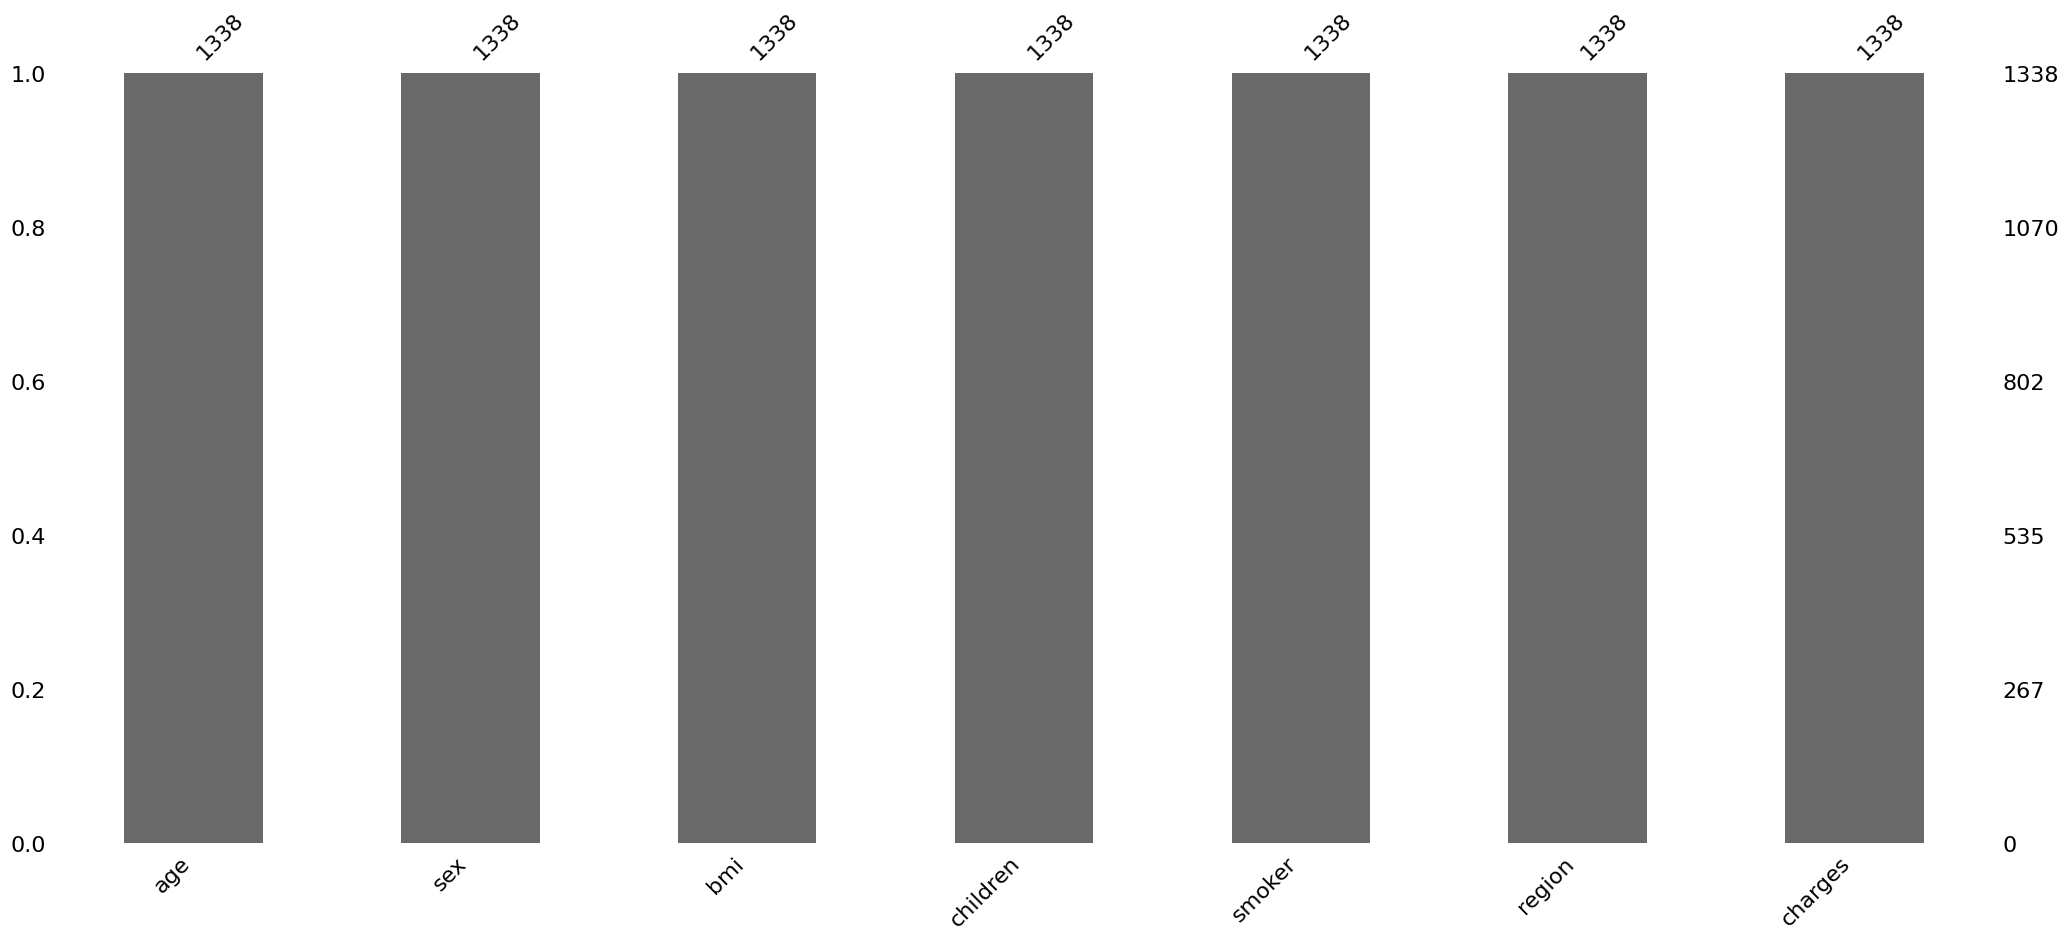

In [ ]:
msno.bar(df)

**Outliers**

In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


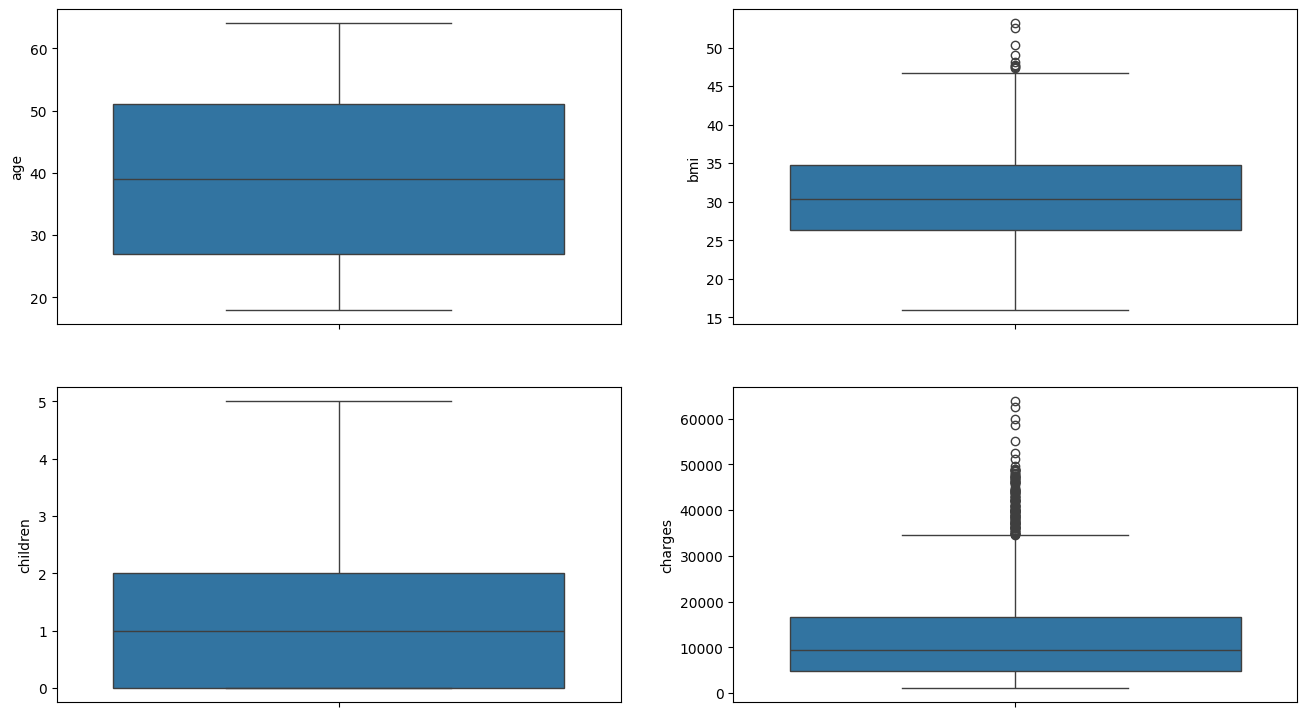

In [ ]:
# define columns with potential outliers
out_cols = ['age', 'bmi', 'children', 'charges']

plt.figure(figsize=(16,9))

# plot boxplot by groups
for i, col in enumerate(out_cols):
  plt.subplot(2,2,i+1)
  sns.boxplot(df[col])
  plt.xlabel('')
  plt.ylabel(col)

We see that 'bmi' has some outliers but they do not exceed much of the IQR value, and since we do not have much data we leave them. For the value of 'charges' we see that there is a considerable amount of outliers. However, since this will be the variable that we want to predict, we do not eliminate outliers so as not to bias the possible predictions that we can obtain.

## Predictive Model (Pre-processing)

Before proceeding to build the architectures, it is necessary to prepare the data and perform the selection of relevant features for the prediction of our target feature (*target feature*).

In [ ]:
# copiamos el dataset
data = df.copy()

**Data leakage**

In [ ]:
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


Analyzing the columns available in the dataset, we see that there are no columns that cannot be known in advance to estimate the cost of the insurance, so there are no sources of data leakage to consider.

**Coding of categorical variables**

In order to analyze the correlation of variables, it is necessary to encode categorical variables into numerical variables. We start by identifying the columns with categorical variables.

In [ ]:
# columns with categorical variables
cat_cols = list(data.columns[data.dtypes == 'O'])
cat_cols

['sex', 'smoker', 'region']

In [ ]:
# we identify the unique values ​​of each categorical column
for c in cat_cols:
  uni_cols = data[c].unique()
  print(c, '(', len(uni_cols), ') : ', uni_cols)

sex ( 2 ) :  ['female' 'male']
smoker ( 2 ) :  ['yes' 'no']
region ( 4 ) :  ['southwest' 'southeast' 'northwest' 'northeast']


To transform categorical variables, it is necessary to consider different coding methods.

When we have a clear hierarchy in the variables (as in the case of months or room type), it is convenient to apply *label encoding*. Likewise, this can be applied when we have categorical variables with high cardinality (as in the case of countries).

When we do not have a hierarchy between variables and/or we have low cardinality, it is convenient to apply *one-hot encoding*. However, in this case we must be careful with the dummy variable trap (*dummy variable trap*), since it may happen that the new columns present a high collinearity between them. To avoid this, we minimize the number of new columns created.

In this case, since the values ​​of the categorical variables are fixed, we can perform the coding before splitting, since in this case there is no risk of data leakage.

In [ ]:
# define categorical encoders
hot_enc = OneHotEncoder(drop='first', sparse=False)

row_size = data.shape[0]

# encoding of 'sex' (one-hot)
col_name = 'sex'
col_1 = np.reshape(np.asarray(data[col_name]), (row_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (row_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_enc'])
data = pd.concat([data, col_df], axis=1)
data.drop(col_name, axis=1, inplace=True)

# encoding of 'smoker' (one-hot)
col_name = 'smoker'
col_1 = np.reshape(np.asarray(data[col_name]), (row_size, 1))
col_2 = np.reshape(hot_enc.fit_transform(col_1), (row_size))
col_df = pd.DataFrame(col_2, columns = [col_name+'_enc'])
data = pd.concat([data, col_df], axis=1)
data.drop(col_name, axis=1, inplace=True)

# encoding of 'region' (one-hot)
col_name = 'region'
enc_cols = pd.get_dummies(data[['region']])
data = data.join(pd.get_dummies(data[['region']]), how='inner') # get_dummies es igual que one-hot encoding
data = data.drop('region', axis=1)

We visualize the dataset after encoding.

In [ ]:
data.head(5)

,age,bmi,children,charges,sex_enc,smoker_enc,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1.0,False,False,False,True
1,18,33.770,1,1725.55230,1.0,0.0,False,False,True,False
2,28,33.000,3,4449.46200,1.0,0.0,False,False,True,False
3,33,22.705,0,21984.47061,1.0,0.0,False,True,False,False
4,32,28.880,0,3866.85520,1.0,0.0,False,True,False,False


In [ ]:
data.dtypes

age                   int64
bmi                 float64
children              int64
charges             float64
sex_enc             float64
smoker_enc          float64
region_northeast       bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object

**Variable correlation**

Taking into account that the column to predict is 'charges', we will analyze which variables have the highest correlation coefficients with this characteristic.

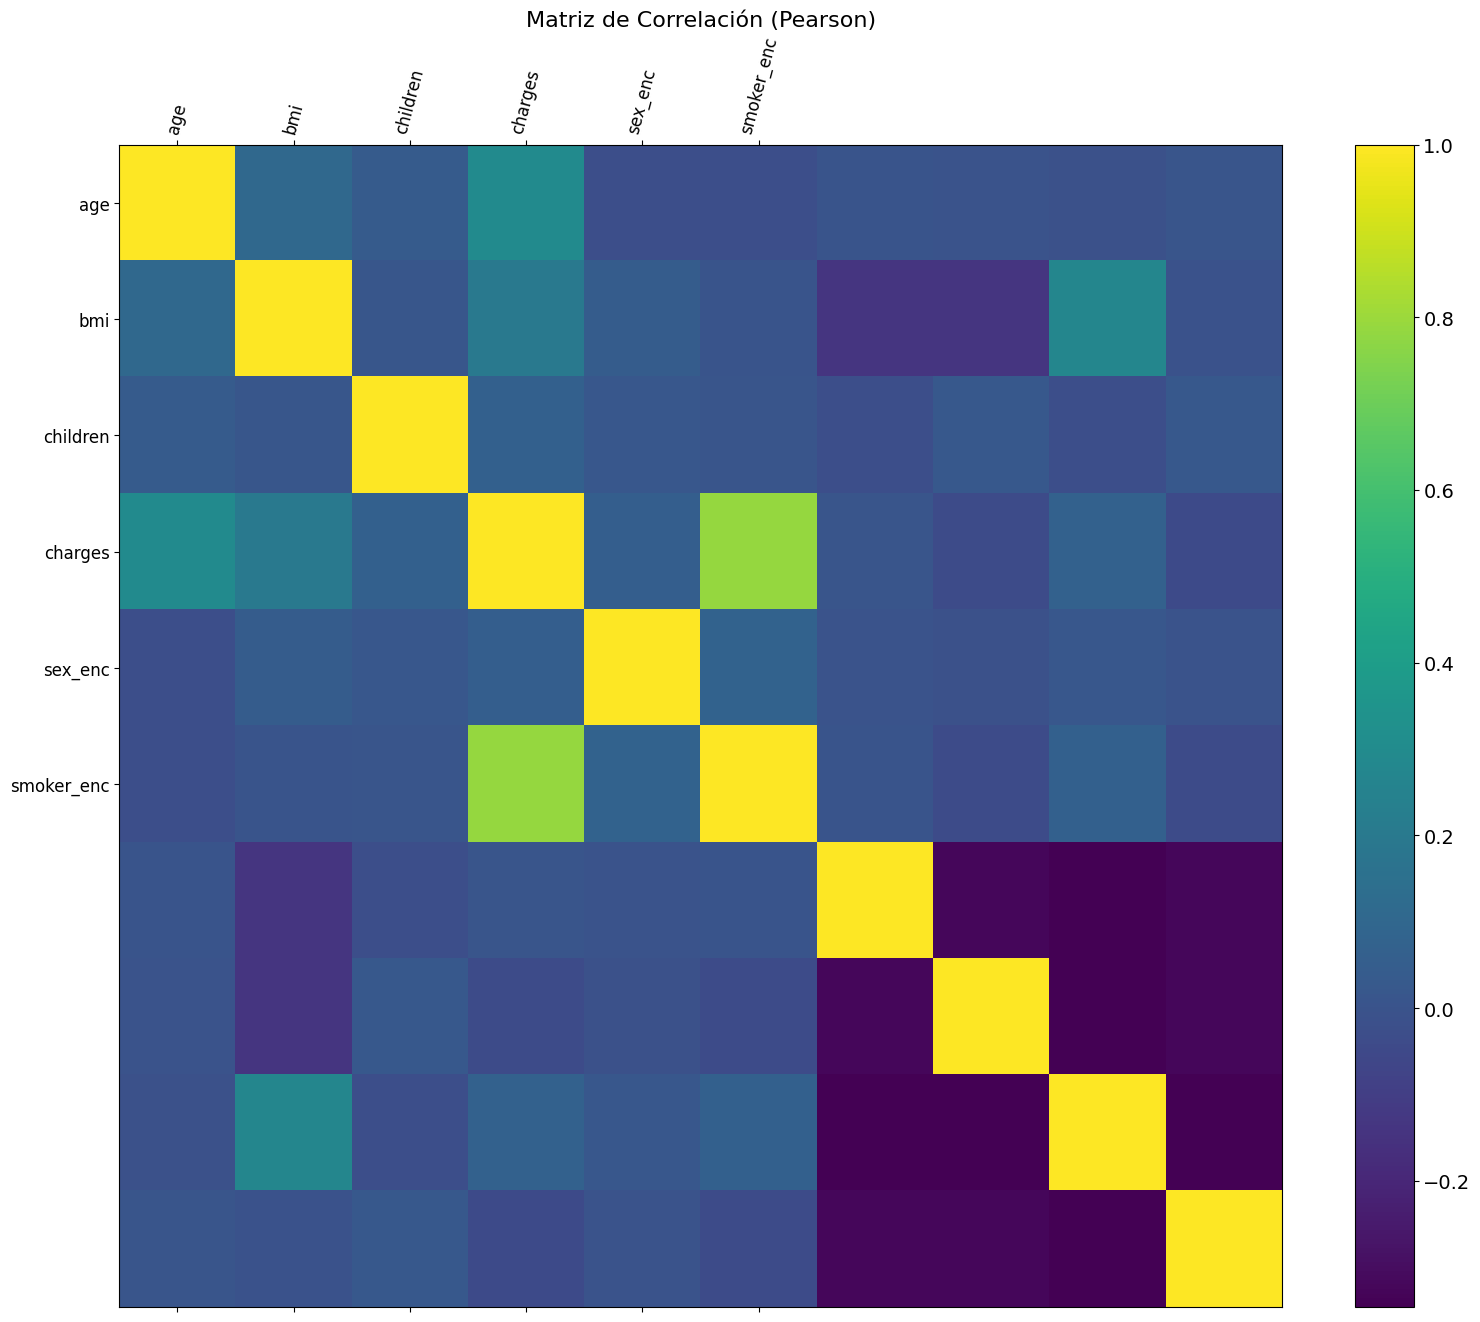

In [ ]:
# calculate correlation matrix
corr_matrix = data.corr('pearson')

# plot correlation matrix
fig = plt.figure(figsize=(19,15))
plt.matshow(corr_matrix, fignum=fig)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12, rotation=75)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix (Pearson)', fontsize=16);

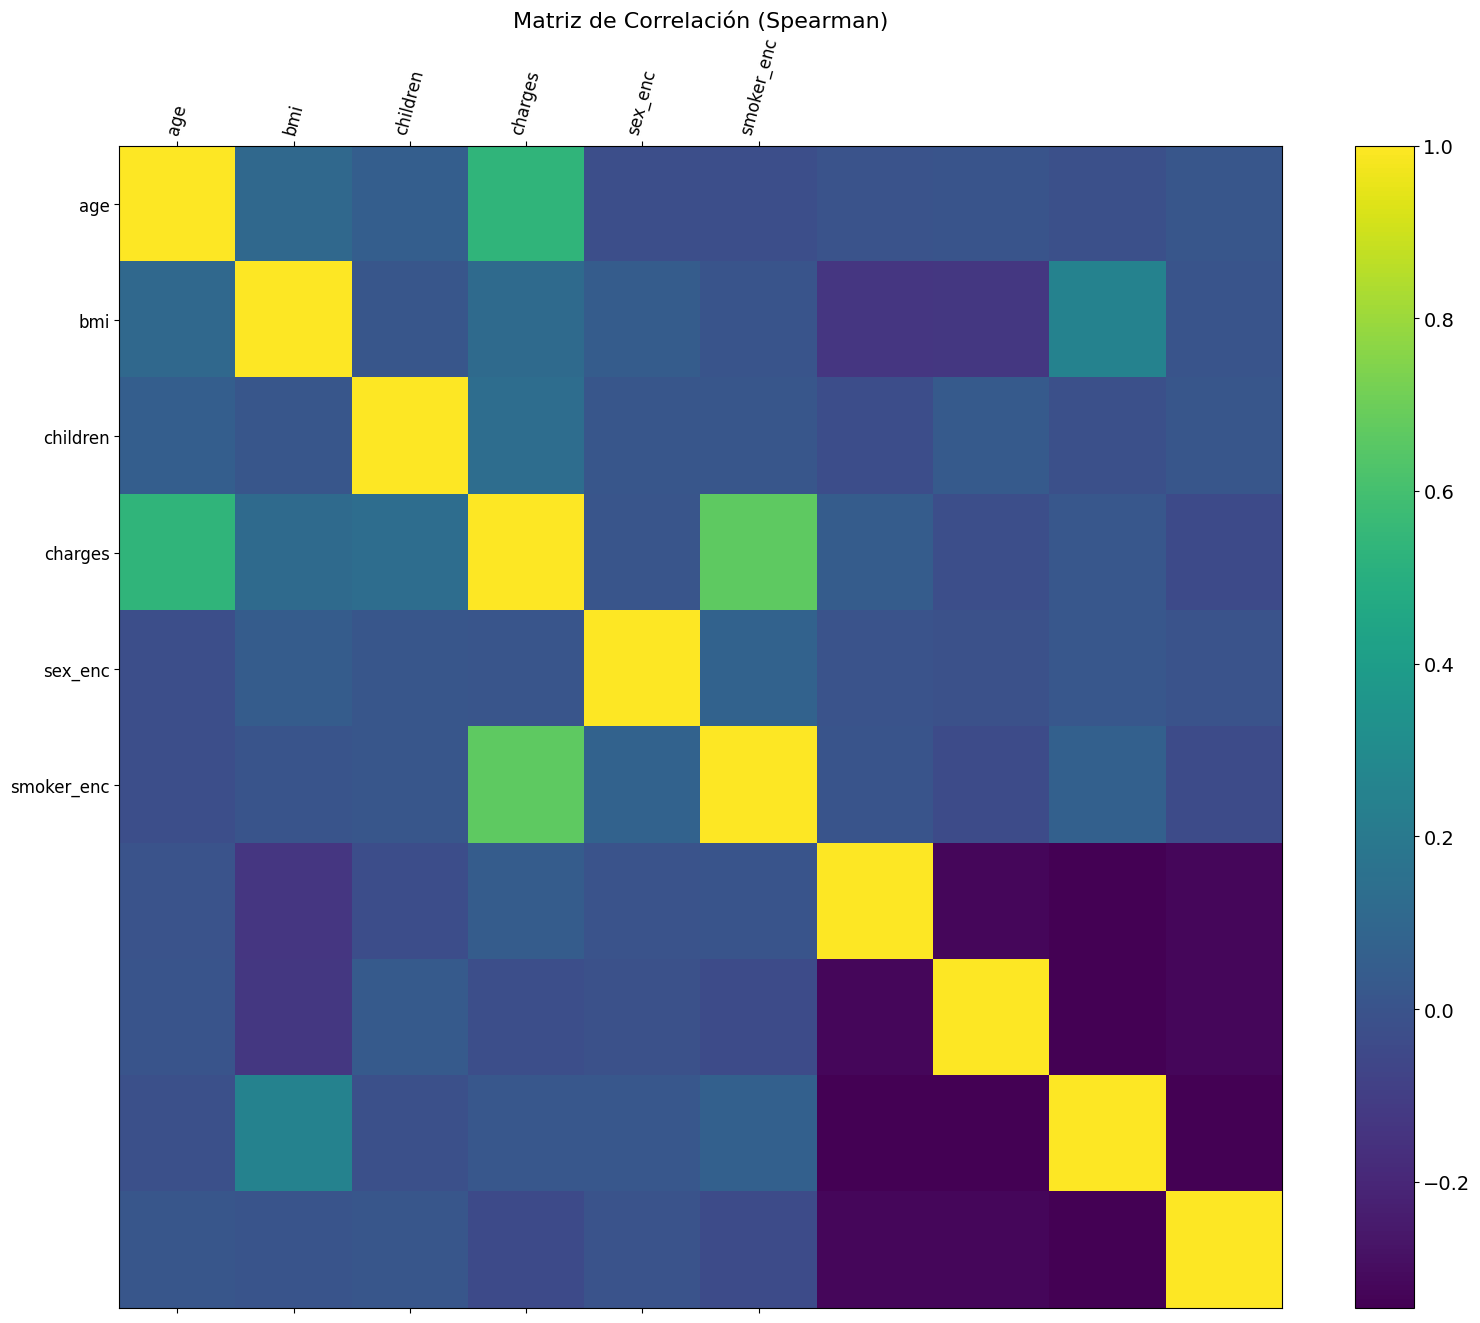

In [ ]:
# calculate correlation matrix
corr_matrix = data.corr('spearman')

# plot correlation matrix
fig = plt.figure(figsize=(19,15))
plt.matshow(corr_matrix, fignum=fig)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12, rotation=75)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix (Spearman)', fontsize=16);

In [ ]:
# get the correlations with respect to the target column
corr_cancel = corr_matrix['charges'].abs().sort_values(ascending=False)
corr_cancel

# show the variables with the highest correlation
list((corr_cancel[(corr_cancel.index != 'charges') & (corr_cancel > 0.10)]).index)

['smoker_enc', 'age', 'children', 'bmi']

We consider variables that have a correlation greater than 10%, and extract a total of 4 features that are likely to be the best for our model prediction. We include sex even if it is not listed because it is reasonable to assume that it influences the price of insurance.

In [ ]:
# guardamos una lista de los features con los nombres originales
features = ['smoker_enc', 'age', 'bmi', 'sex_enc']

target = 'charges'

**Separation of data sets**

Once the variables to be used in our models have been chosen, it is necessary to start by separating the data into a training set and a validation set. We follow the standard methodology where 70% of the original set will be for training, and 30% will be for validation.

In [ ]:
# quitar nulos
data = data.dropna()

# separamos las características a considerar
X = data[features]
y = data[target]

# separacion de conjuntos de entrenamiento y validacion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
X_train.shape, X_test.shape

((1003, 4), (335, 4))

**Separate encoding**

If the encoded values ​​are always constant in the data (e.g. gender of the person), we can do the encoding before data separation, without the risk of having the *data leakage* problem.

**Renormalization**

Since we have a large range of numerical variables, we renormalize the training and validation sets separately. This will help improve the performance of the models.

In [ ]:
# numerical columns
for col in X_train.columns:
  print(col, max(X_train[col]))

smoker_enc 1.0
age 64
bmi 53.13
sex_enc 1.0


In [ ]:
# TOTAL DATASET

# normalization of 'age'
col_name = 'age'
X[col_name] = np.log(X[col_name]+1)

# normalization of 'bmi'
col_name = 'bmi'
X[col_name] = np.log(X[col_name]+1)

X.head(3)

,smoker_enc,age,bmi,sex_enc
0,1.0,2.995732,3.363842,0.0
1,0.0,2.944439,3.548755,1.0
2,0.0,3.367296,3.526361,1.0


In [ ]:
# TRAINING DATASET

# normalization of 'bmi'
col_name = 'age'
X_train[col_name] = np.log(X[col_name]+1)

# normalization of 'age'
col_name = 'bmi'
X_train[col_name] = np.log(X[col_name]+1)

X_train.head(3)

,smoker_enc,age,bmi,sex_enc
1043,0.0,1.474144,1.455914,0.0
968,0.0,1.408800,1.455435,1.0
594,0.0,1.555545,1.551786,1.0


In [ ]:
# VALIDATION DATASET

# normalization of 'age'
col_name = 'age'
X_test[col_name] = np.log(X[col_name]+1)

# normalization of 'bmi'
col_name = 'bmi'
X_test[col_name] = np.log(X[col_name]+1)

X_test.head(3)

,smoker_enc,age,bmi,sex_enc
559,0.0,1.385227,1.525651,1.0
1087,0.0,1.621454,1.500174,1.0
1020,0.0,1.599639,1.534194,1.0


We now proceed to make the predictions with three models. Although the exercise only requests the cross validation metric (*cross validation score*), since we have divided the training and validation sets we can additionally calculate additional metrics that will allow us to complement said information.

## Predictive model (Linear Regression)

In [ ]:
# define and train model
lgr = LinearRegression() # scikit-learn
lgr.fit(X_train, y_train)

# make predictions
lgr_pred = lgr.predict(X_test)

In [ ]:
# evaluation metrics
mae = mean_absolute_error(y_test, lgr_pred)
print('MEAN ABSOLUTE ERROR')
print(round(mae,2), round(100*mae/np.mean(lgr_pred),2), '%')

mse = np.sqrt(mean_squared_error(y_test, lgr_pred))
print('MEAN SQUARED ERROR')
print(round(mse,2), round(100*mse/np.mean(lgr_pred),2), '%')

r2s = r2_score(y_test, lgr_pred)
print('DETERMINATION COEFFICIENT')
print(round(r2s, 2))

ERROR MEDIO ABSOLUTO
4212.64 32.53 %
ERROR CUADRATICO MEDIO
6121.83 47.27 %
COEFICIENTE DE DETERMINACION
0.72


We can visualize some examples of what the prediction looks like compared to the observed value.

In [ ]:
df_res = pd.DataFrame({'Charges (Observado)': y_test, 'Charges (Predicho)': lgr_pred})
df_res.reset_index(inplace=True)
df_res.drop('index', axis=1, inplace=True)

X_test.reset_index().drop('index', axis=1).join(df_res.sample(10), how='inner')

,smoker_enc,age,bmi,sex_enc,Charges (Observado),Charges (Predicho)
60,0.0,1.481877,1.525651,0.0,3366.66970,8257.228718
70,1.0,1.603479,1.519318,1.0,60021.39897,36657.365174
117,0.0,1.640720,1.449543,0.0,14254.60820,11280.600123
132,0.0,1.539779,1.472837,0.0,7144.86265,8254.561439
139,0.0,1.574565,1.541340,0.0,7935.29115,12669.758152
141,0.0,1.522467,1.518298,1.0,5934.37980,9316.669096
223,0.0,1.466077,1.384035,1.0,4827.90495,1136.296592
233,0.0,1.516302,1.385227,0.0,6753.03800,3451.388339
269,0.0,1.607232,1.413195,1.0,10065.41300,8088.260431
332,0.0,1.603479,1.495557,0.0,23045.56616,11813.103297


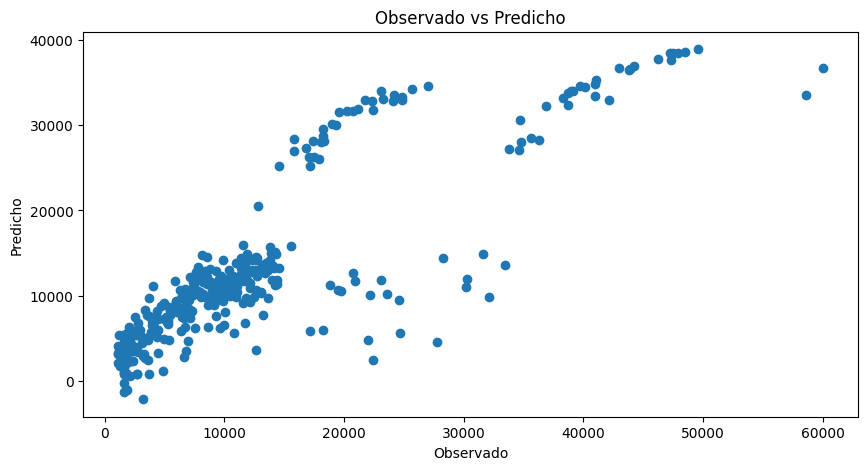

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, lgr_pred)

plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs Predicted')
plt.show()

## Predictive Model (XG Boost)

In [ ]:
# define and train model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# make predictions
xgb_pred = xgb.predict(X_test)

In [ ]:
# evaluation metrix
mae = mean_absolute_error(y_test, xgb_pred)
print('MEAN ABSOLUTE ERROR')
print(round(mae,2), round(100*mae/np.mean(xgb_pred),2), '%')

mse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print('MEAN SQUARED ERROR')
print(round(mse,2), round(100*mse/np.mean(xgb_pred),2), '%')

r2s = r2_score(y_test, xgb_pred)
print('DETERMINATION COEFFICIENT')
print(round(r2s, 2))

ERROR MEDIO ABSOLUTO
3084.43 23.24 %
ERROR CUADRATICO MEDIO
5424.76 40.88 %
COEFICIENTE DE DETERMINACION
0.78


We can visualize some examples of what the prediction looks like compared to the observed value.

In [ ]:
df_res = pd.DataFrame({'Charges (Observado)': y_test, 'Charges (Predicho)': xgb_pred})
df_res.reset_index(inplace=True)
df_res.drop('index', axis=1, inplace=True)

X_test.reset_index().drop('index', axis=1).join(df_res.sample(10), how='inner')

,smoker_enc,age,bmi,sex_enc,Charges (Observado),Charges (Predicho)
2,0.0,1.599639,1.534194,1.0,8798.59300,11250.124023
55,0.0,1.503301,1.571017,0.0,3994.17780,4621.602539
65,0.0,1.587564,1.505312,1.0,8765.24900,10319.208984
74,0.0,1.637663,1.489445,1.0,13352.09980,16936.679688
125,0.0,1.587564,1.518174,1.0,9563.02900,10269.902344
160,0.0,1.509918,1.491109,1.0,3704.35450,5761.468262
168,0.0,1.618011,1.467718,0.0,11073.17600,12274.309570
207,0.0,1.560500,1.459192,0.0,7046.72220,8357.488281
219,1.0,1.570003,1.490749,1.0,38998.54600,52199.667969
334,0.0,1.570003,1.487361,1.0,32108.66282,8229.552734


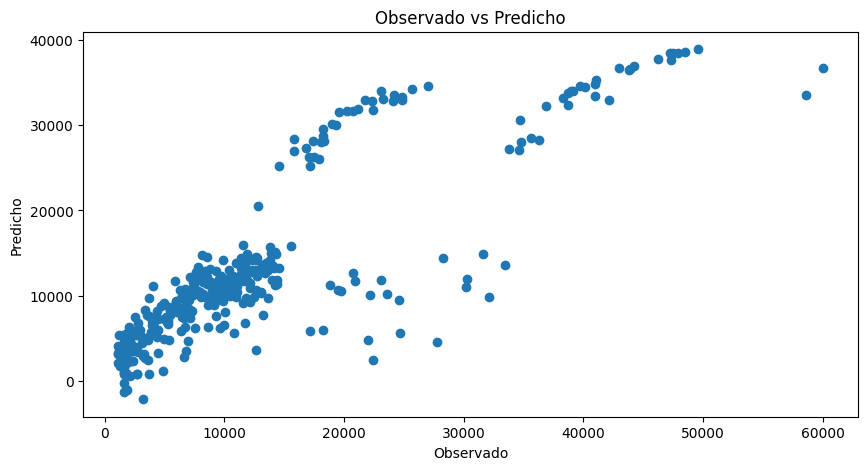

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, lgr_pred)
plt.xlabel('Observed')
plt.ylabel('Prediction')
plt.title('Observed vs Predicted')
plt.show()

## Predictive Model (RF Regressor)

In [ ]:
# define and train model
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

# make predictions
rfr_pred = rfr.predict(X_test)

In [ ]:
# evaluation metric
mae = mean_absolute_error(y_test, rfr_pred)
print('MEAN ABSOLUTE ERROR')
print(round(mae,2), round(100*mae/np.mean(rfr_pred),2), '%')

mse = np.sqrt(mean_squared_error(y_test, rfr_pred))
print('MEAN SQUARED ERROR')
print(round(mse,2), round(100*mse/np.mean(rfr_pred),2), '%')

r2s = r2_score(y_test, rfr_pred)
print('DETERMINATION COEFFICIENT')
print(round(r2s, 2))

ERROR MEDIO ABSOLUTO
2989.02 22.32 %
ERROR CUADRATICO MEDIO
5143.25 38.41 %
COEFICIENTE DE DETERMINACION
0.8


We can visualize some examples of what the prediction looks like compared to the observed value.

In [ ]:
df_res = pd.DataFrame({'Charges (Observado)': y_test, 'Charges (Predicho)': xgb_pred})
df_res.reset_index(inplace=True)
df_res.drop('index', axis=1, inplace=True)

X_test.reset_index().drop('index', axis=1).join(df_res.sample(10), how='inner')

,smoker_enc,age,bmi,sex_enc,Charges (Observado),Charges (Predicho)
1,0.0,1.621454,1.500174,1.0,11353.22760,19458.451172
35,0.0,1.607232,1.442579,1.0,9863.47180,16968.880859
70,1.0,1.603479,1.519318,1.0,60021.39897,42772.414062
113,0.0,1.640720,1.557171,1.0,15555.18875,13906.028320
156,0.0,1.599639,1.505312,1.0,9964.06000,10195.642578
233,0.0,1.516302,1.385227,0.0,6753.03800,6106.197266
242,0.0,1.637663,1.533398,0.0,31620.00106,12049.966797
260,0.0,1.570003,1.487912,0.0,8219.20390,8176.952637
267,0.0,1.522467,1.458721,0.0,5227.98875,5736.246094
317,0.0,1.591686,1.498867,1.0,9290.13950,11186.334961


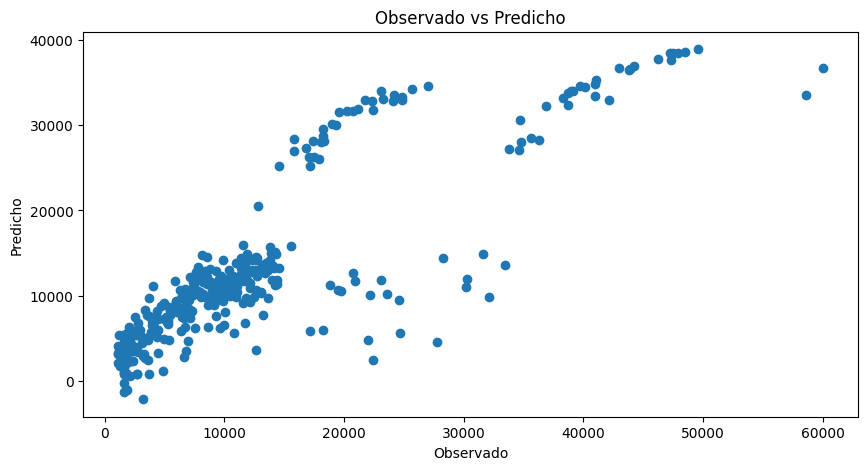

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, lgr_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs Predicted')
plt.show()

## Hyperparameter search

The previous models were trained with the default model parameters. However, we can improve performance by performing hyperparameter tuning.

We can do this manually based on the knowledge we have about the model, or we can automate it by searching the model, that is, iterating the model with different combinations until we find the set that maximizes the precision of the model.

**XGB Regressor**

In [ ]:
# model parameters
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# define the default estimator
xgb = XGBRegressor()

# define parameter space (dictionary)
param_grid= {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
             'n_estimators': [50, 100, 150, 200, 250, 300]}

# configure network search
clf = GridSearchCV(xgb, param_grid, n_jobs=4)

# do the training
search = clf.fit(X_train, y_train)

# show results
print('best_params:', search.best_params_)
print('PRECISIÓN: ', round(search.score(X_test, y_test), 4))

best_params: {'max_depth': 3, 'n_estimators': 50}
PRECISIÓN:  0.8461


In [ ]:
xgb = XGBRegressor(max_depth=3, n_estimators=50, n_jobs=4)
best_model = xgb.fit(X_train, y_train)

In [ ]:
xgb_pred = best_model.predict(X_test)

# evaluation metrics
mae = mean_absolute_error(y_test, xgb_pred)
print('MEAN ABSOLUTE ERROR')
print(round(mae,2), round(100*mae/np.mean(xgb_pred),2), '%')

mse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print('MEAN SQUARED ERROR')
print(round(mse,2), round(100*mse/np.mean(xgb_pred),2), '%')

r2s = r2_score(y_test, xgb_pred)
print('DETERMINATION COEFFICIENT')
print(round(r2s, 2))

ERROR MEDIO ABSOLUTO
2614.7 19.96 %
ERROR CUADRATICO MEDIO
4550.39 34.74 %
COEFICIENTE DE DETERMINACION
0.85


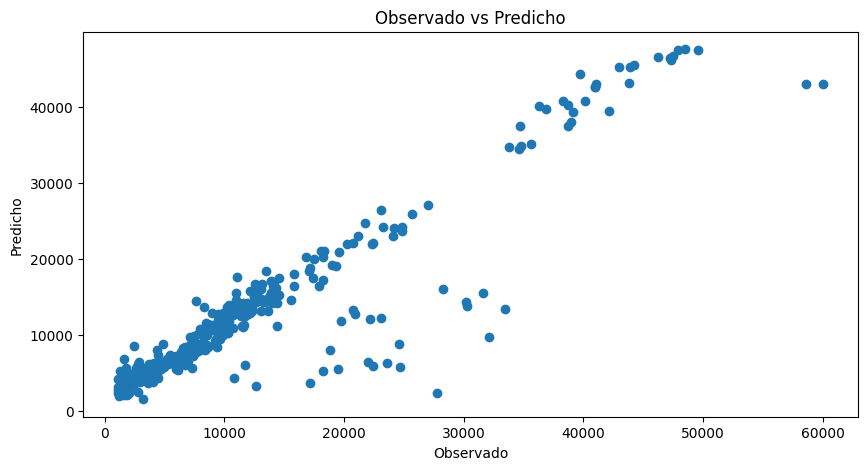

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, xgb_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs Predicted')
plt.show()

In [ ]:
# create results dataframe
df_res = pd.DataFrame({'Charges (Observado)': y_test, 'Charges (Predicho)': xgb_pred})
df_res.reset_index(inplace=True)
df_res.drop('index', axis=1, inplace=True)

X_test.reset_index().drop('index', axis=1).join(df_res.sample(10), how='inner')

,smoker_enc,age,bmi,sex_enc,Charges (Observado),Charges (Predicho)
15,0.0,1.587564,1.490749,1.0,8968.33000,10671.890625
49,0.0,1.621454,1.480241,0.0,14394.39815,11152.338867
86,0.0,1.560500,1.451513,0.0,7045.49900,8138.313965
145,0.0,1.614495,1.471320,1.0,10594.50155,13462.570312
160,0.0,1.509918,1.491109,1.0,3704.35450,6162.437988
162,0.0,1.624826,1.503368,1.0,11946.62590,12765.374023
191,1.0,1.603479,1.559520,1.0,47269.85400,46477.019531
263,1.0,1.545194,1.524276,1.0,40103.89000,40842.699219
285,0.0,1.595709,1.500585,0.0,10118.42400,10800.922852
290,0.0,1.614495,1.492901,0.0,10704.47000,12681.329102
